In [1]:
%pip install sentencepiece
%pip install wandb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
#!g2.1
import json
from torch.utils.data import DataLoader
import sentencepiece as spm
from dataset import TinyStoriesDataset
from train import *
from model import *
import torch
import matplotlib.pyplot as plt

/home/kolya/Univer/homeworks_4/DL2/bhw1/train.py:190: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  inputs["input_ids"] = torch.cat((inputs["input_ids"], torch.tensor([pred_token][:, None])), dim=-1)
/home/kolya/.local/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [3]:
!wget --quiet --show-progress "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories_all_data.tar.gz"

... .......... .......... 79% 82.3M 6s
1245700K .......... .......... .......... .......... .......... 79% 75.0M 6s
1245750K .......... .......... .......... .......... .......... 79% 74.6M 6s
1245800K .......... .......... .......... .......... .......... 79% 86.4M 6s
1245850K .......... .......... .......... .......... .......... 79%  112M 6s
1245900K .......... .......... .......... .......... .......... 79% 63.6M 6s
1245950K .......... .......... .......... .......... .......... 79% 86.2M 6s
1246000K .......... .......... .......... .......... .......... 79% 87.9M 6s
1246050K .......... .......... .......... .......... .......... 79%  319M 6s
1246100K .......... .......... .......... .......... .......... 79% 51.8M 6s
1246150K .......... .......... .......... .......... .......... 79% 83.6M 6s
1246200K .......... .......... .......... .......... .......... 79% 45.2M 6s
1246250K .......... .......... .......... .......... .......... 79%  258M 6s
1246300K .......... .......... ......

In [4]:
!tar xvzf TinyStories_all_data.tar.gz

./
./data22.json
./data34.json
./data18.json
./data04.json
./data07.json
./data30.json
./data47.json
./data15.json
./data21.json
./data39.json
./data17.json
./data03.json
./data01.json
./data36.json
./data14.json
./data06.json
./data28.json
./data43.json
./data23.json
./data38.json
./data40.json
./data10.json
./data19.json
./data20.json
./data29.json
./data11.json
./data46.json
./data33.json
./data25.json
./data42.json
./data13.json
./data49.json
./data27.json
./data24.json
./data32.json
./data41.json
./data26.json
./data37.json
./data09.json
./data05.json
./data45.json
./data16.json
./data00.json
./data48.json
./data12.json
./data02.json
./data44.json
./data35.json
./data31.json
./data08.json


In [6]:
!mv data*.json jsons/

In [2]:
#!g2.1
%load_ext autoreload
%autoreload 2

In [ ]:
import json
with open("jsons/data00.json") as f:
    string = f.readline()
    js = json.loads(string)
    for story in js:
        print("-----------")
        print(story["story"])
        break

In [3]:
#!g2.1
#tokenization file
import os
import json

files = sorted(os.listdir("jsons/"))
with open("tokenization_file", "w+") as f:
    for file in tqdm(files[:10]):
        with open(f"jsons/{file}", 'r') as g:
            stories = json.loads(g.readline())
            for story in stories:
                f.write(story["story"])
        g.close()
f.close()

spm.SentencePieceTrainer.train(
    input="tokenization_file",
    vocab_size=5000,
    model_type="bpe",
    model_prefix="tiny_stories_5k",
    pad_id=0, bos_id=1, eos_id=2, unk_id=3
)
tokenizer = spm.SentencePieceProcessor(model_file="tiny_stories_5k.model")

In [9]:
!wc -l tokenization_file

3206341 tokenization_file


In [4]:
#!g2.1
from tqdm import tqdm
#datasets
files = ["a", "a"]
train_dataset = TinyStoriesDataset(files=files[:-1], tokenizer=tokenizer, load_from_memory=True, filename='train_dataset.pt')
val_dataset = TinyStoriesDataset(files=[files[-1]], tokenizer=tokenizer, load_from_memory=True, filename='val_dataset.pt')

torch.int64
torch.int64


In [5]:
#!g2.1
len(train_dataset)

4900000

In [39]:
torch.save(train_dataset.corpus, "train_dataset.pt")

In [40]:
torch.save(val_dataset.corpus, "val_dataset.pt")

In [14]:
tokenizer.decode(tokenizer.encode("Hello, \" How are you??? I want to meet with you! I don't want to speak in chat", add_eos=True))

'Hello, " How are you??? I want to meet with you! I don\'t want to speak in chat'

In [15]:
#!g2.1
len(val_dataset)

67871

In [6]:
#!g2.1
device = torch.device("cuda:0")

In [7]:
#!g2.1
!nvidia-smi

Tue Nov 28 19:59:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:8C:00.0 Off |                    0 |
| N/A   29C    P0    49W / 500W |      9MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
#!g2.1
torch.cuda.empty_cache()

In [45]:
#!g2.1
from model import BoutiqueLM
decoder = BoutiqueLM(
    vocab_stories_size=5000,
    num_layers=8,
    num_heads=8,
    hidden_dim=512,
    activation=nn.GELU,
    max_len=10000
).to(device)

In [8]:
#!g2.1
decoder.positional_encoding.cos_cached

In [9]:
#!g2.1
sum(p.numel() for p in decoder.parameters())

30285824

In [47]:
sum(p.numel() for p in decoder.parameters() if p.requires_grad)

30285824

In [9]:
#!g2.1
num_workers = 2
lr = 1e-3
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=9600, pct_start=0.1, final_div_factor=10, div_factor=10)
train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=num_workers
)

In [10]:
#!g2.1
def _save_checkpoint(model, optimizer, epoch, save_best=False, only_best=False):
        """
        Saving checkpoints

        :param epoch: current epoch number
        :param save_best: if True, rename the saved checkpoint to 'model_best.pth'
        """
        arch = type(model).__name__
        state = {
            "arch": arch,
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        filename = str("checkpoint-epoch{}.pth".format(epoch))
        if not (only_best and save_best):
            torch.save(state, filename)
#             logger.info("Saving checkpoint: {} ...".format(filename))
        if save_best:
            best_path = str("model_best.pth")
            torch.save(state, best_path)
#             logger.info("Saving current best: model_best.pth ...")

In [11]:
#!g2.1
wandb.login(key="", relogin=True) #delete my wandb key, if don't want to log, set wandb_log=False in train call

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [12]:
# #!g2.1
# wandb.init(project="DL bhw-1",
#           entity="kilka74",
#           name="full data new version transformer with flash-attention",
#           config={
#               "batch_size":2048,
#               "seq_len":256,
#               "embed_dim":512,
#               "num_heads":8,
#               "num_layers":8,
#               "tokenizetion":"BPE",
#               "vocab_size":5000,
#               "lr": 1e-3,
#               "train_size": 4900000,
#               "weight_decay":0,
#               "beta1":0.9,
#               "beta2":0.95
#           })

wandb: Currently logged in as: kilka74. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20231128_200011-u778bdrr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run full data new version transformer with flash-attention
wandb: ⭐️ View project at https://wandb.ai/kilka74/DL%20bhw-1
wandb: 🚀 View run at https://wandb.ai/kilka74/DL%20bhw-1/runs/u778bdrr


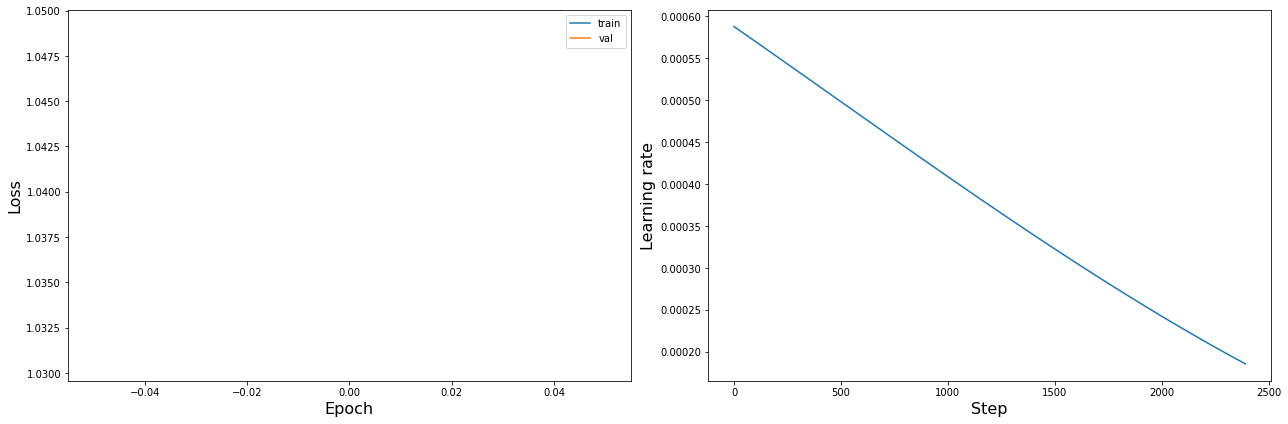

9567it [53:10,  3.00it/s]


ValueError: Tried to step 9601 times. The specified number of total steps is 9600

In [16]:
#!g2.1
from model import *
train(
    model=decoder,
    num_epochs=4,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    wandb_log=True,
    device=torch.device("cuda:0")
)

_save_checkpoint(decoder, optimizer, 4)
wandb.finish()

In [54]:
#!g2.1
_save_checkpoint(decoder, optimizer, 4)

**Генерация историй**

In [8]:
#!g2.1
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
tokenizer = spm.SentencePieceProcessor(model_file="tiny_stories_5k.model")
d = torch.load('checkpoint-epoch4.pth', map_location=torch.device('cpu'))

In [49]:
boutique_lm = BoutiqueLM(
    vocab_stories_size=5000,
    num_layers=8,
    num_heads=8,
    hidden_dim=512,
    activation=nn.GELU,
    max_len=10000
)

boutique_lm.load_state_dict(d['state_dict'])

<All keys matched successfully>